In [34]:
# importing libraries and custom classes required
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import *
%matplotlib inline
print ('Data Loaded!')

Data Loaded!


In [35]:
# loading test and train data
data = pd.read_csv('D:\Cheenu\Exoplanet\Kaggle Data\exoTrain.csv')
dfTest = pd.read_csv('D:\Cheenu\Exoplanet\Kaggle Data\exoTest.csv')
data.tail(3)

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
3957,1,144.47,20.09,147.47,109.18,100.87,24.87,115.03,106.37,48.87,...,-57.53,-41.94,-165.94,-265.13,-263.35,-376.53,-176.22,-152.07,-216.60,-202.97
3958,1,374.46,326.06,319.87,338.23,251.54,209.84,186.35,167.46,135.45,...,-123.55,-166.90,-222.44,-209.71,-180.16,-166.83,-235.66,-213.63,-205.99,-194.07
3959,1,-54.01,-44.13,-41.23,-42.82,-39.47,-24.88,-31.14,-24.71,-13.12,...,-0.73,-1.64,1.58,-4.82,-11.93,-17.14,-4.25,5.47,14.46,18.70


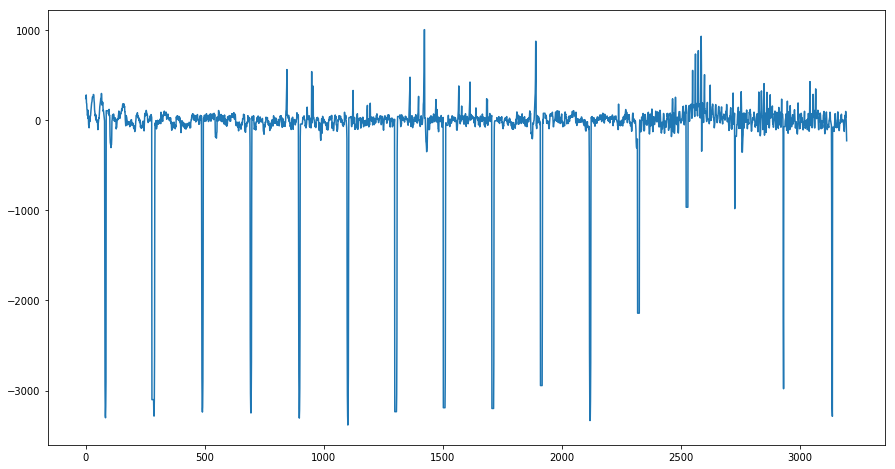

In [36]:
# Visualize data before noise removal
i = 6
plt.figure(figsize=(15, 8))
plt.plot(np.asarray(data.iloc[i,1:]))

In [37]:
# Removing noise from the data using custom made funtions to
# detect the outliers and normalize them.

f, k = 2.5, 1
def cal(mean, std, f):
    return mean + f*std

def modify(data, f, k):
    y_train = data.iloc[:, 0]
    X_train = data.iloc[:, 1:]
    y_train_2 = np.array(y_train, copy = False, subok = True, ndmin = 2).T
    X_train_lim = cal(X_train.mean(axis = 1), X_train.std(axis = 1), f)
    dump, n = X_train.shape
    masks = np.zeros((dump, n), dtype = np.bool_)
    for i in range(n):
        masks[:, i] = np.greater_equal(X_train.iloc[:, i], X_train_lim)
    X_out = np.copy(X_train)
    for i in range(n):
        if (i >= k and i < (n - k)):
            X_out[:, i] = (np.logical_not(masks[:, i]) * X_out[:, i]) + \
            masks[:, i] * (X_train.iloc[:, range(i - k, i)].mean(axis = 1) + \
                           X_train.iloc[:, range(i + 1, i + k + 1)].mean(axis = 1)) / 2
                        
        else:
            X_out[:, i] = (np.logical_not(masks[:, i]) * X_out[:, i]) +\
            masks[:, i] * (X_train.mean(axis = 1))
    return pd.DataFrame(np.concatenate((y_train_2, X_out), axis = 1))

data_n = modify(data, f, k)
dfTest_n = modify(dfTest, f, k)

In [38]:
# deleting the initial data structures.
del data
del dfTest

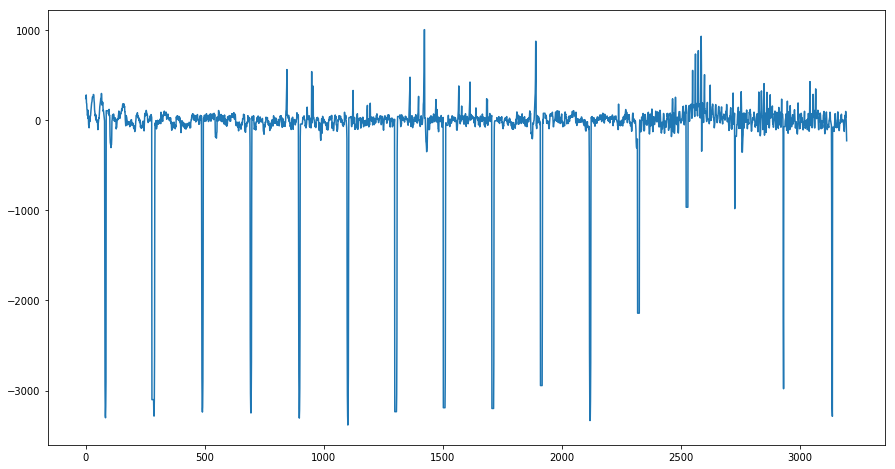

In [39]:
#data after noise removal
plt.figure(figsize=(15, 8))
plt.plot(np.asarray(data_n.iloc[i,1:]))

In [40]:
# Oversampling the data using SMOTE from imblearn to
# create synthetic data to the balance the under represented class 
y = np.array(data_n.iloc[:, 0])
X = np.array(data_n.iloc[:, 1:])
X_r, y_r = SMOTE(k_neighbors = 8, random_state = 32).fit_sample(X, y)
y_2 = np.array(y_r, copy=False, subok=True, ndmin=2).T
data_n_s = pd.DataFrame(np.concatenate((y_2, X_r), axis = 1))

In [41]:
# deleting the initial data structures.
del data_n

In [42]:
# Finding the first order differences
def diff(data):
    y = np.array(data.iloc[:, 0])
    X = np.array(data.iloc[:, 1:])
    y_2 = np.array(y, copy=False, subok=True, ndmin=2).T
    X = np.diff(X, n=2)
    return pd.DataFrame(np.concatenate((y_2, X), axis = 1))

data_n_s_1d = diff(data_n_s)
dfTest_n_1d = diff(dfTest_n)

In [43]:
# deleting the initial data structures.
del data_n_s
del dfTest_n

In [44]:
# synthetic data appended to the initial data
data_n_s_1d.tail(3)

,0,1,2,3,4,5,6,7,8,9,...,3186,3187,3188,3189,3190,3191,3192,3193,3194,3195
7851,2.0,-2.577290,1.421771,9.864485,-15.296787,8.017492,9.597335,-3.409546,-6.589898,-11.972980,...,9.337687,-12.765307,10.454051,15.733835,-13.888456,12.803416,-19.988690,-5.848205,11.552250,-9.112127
7852,2.0,-130.241963,3.501853,22.147058,-3.964405,-13.639542,9.815321,9.750334,-27.442794,27.480421,...,24.809554,-1.115176,-9.537522,-10.964966,29.530365,19.705492,-46.279795,18.628451,7.230214,-7.891330
7853,2.0,-24.995727,12.627993,6.315566,-12.359147,-16.215113,27.587324,0.076619,-15.699473,4.877173,...,-12.554404,5.374899,-7.093299,16.683098,-7.414623,8.549105,-19.231866,13.505246,-4.226302,-4.854062


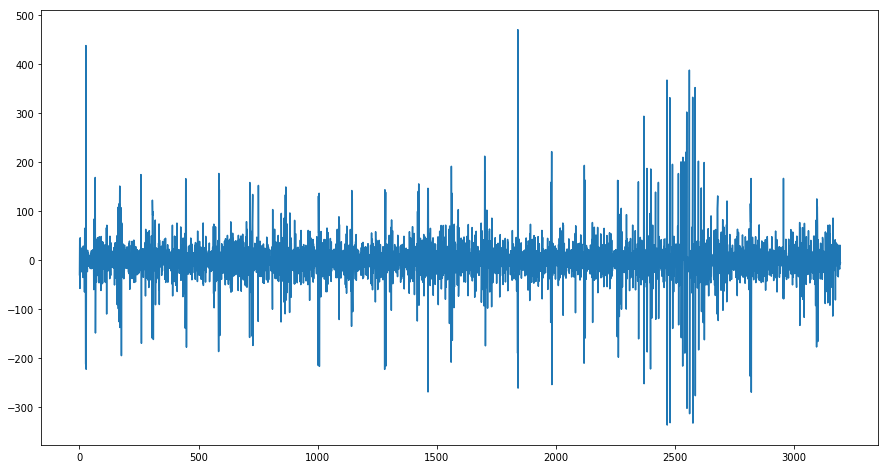

In [45]:
# data after 1st order difference (for the 0th index time series flux data)
plt.figure(figsize=(15, 8))
plt.plot(np.asarray(data_n_s_1d.iloc[0,1:]))

In [46]:
# setting up the features and Labels to be put to the classifier
y_test = np.array(dfTest_n_1d.iloc[:, 0])
X_test = np.array(dfTest_n_1d.iloc[:, 1:])
y = np.array(data_n_s_1d.iloc[:, 0])
X = np.array(data_n_s_1d.iloc[:, 1:])

In [47]:
# applying the classifier and predicting on the amplified feature.
clf_r = RandomForest(random_state = 9)
clf_r = clf_r.fit(X, y)
prediction_r = clf_r.predict(X_test)
(pd.DataFrame(prediction_r)).shape

NameError: name 'RandomForest' is not defined

In [32]:
from sklearn.metrics import confusion_matrix, f1_score
print (f1_score(y_test, prediction_r), '\n', confusion_matrix(y_test, prediction_r))

ValueError: Classification metrics can't handle a mix of continuous and binary targets

In [ ]:
np.savetxt('p.csv', prediction_r, fmt = '%.1u', header = 'LABEL', delimiter = ',')

In [ ]:
# index [starting form 0] which was predicted to be the exoplanets
np.nonzero(prediction_r - 1)